# Project - Detection of artefacts PPG/ABP/ECG signals
Macabiau Clara - MSc 

Last update : nov 2022

In [1]:
#Importing libraries
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import wfdb 
#from kneed import DataGenerator, KneeLocator
from sklearn.preprocessing import StandardScaler #standardize features by removing the mean and scaling to unit variances
from sklearn.preprocessing import minmax_scale

In [2]:
#Importing sub-functions
%run find_signal.ipynb 
%run classification.ipynb 
%run preprocessing.ipynb 
%run pca.ipynb 
%run pearson.ipynb 
%run energy_ratio.ipynb 

In [3]:
#Variable
new_freq=256 #new frequency for resampling (Hz)

### 1) Detection of artefacts in PPG signals using PCA method 
This first method aims to create model signals, using the PCA method, and then to compare 2 model signals to 1 acquired signal. This comparison is done using the Pearson correlation matrix and by comparing the values of this matrix against a defined threshold the pulses of the acquired signal are classified as good or with artifacts.

REF : https://doi.org/10.1088/1361-6579/aadf1e 

In [4]:
#Code to add in a list the name of the files that are in folders: good_files and files_to_classify 
import os
from os import listdir

path1='/Users/claramacabiau/Documents/Canada/Projet_Recherche/CODES/python/wfdb-python-main/functions/database_Clara/files_to_classify'
path2='/Users/claramacabiau/Documents/Canada/Projet_Recherche/CODES/python/wfdb-python-main/functions/database_Clara/good_files'
files_to_classify=[]
good_files=[]
for f in listdir(path1):
    if f.endswith(".dat"): #each file has a .dat (data) and .hea (header with file info) file, this line is to take only the data 
        f=os.path.splitext(f)[0] #remove the extension of the file 
        files_to_classify.append(f) #add to the list

for f in listdir(path2): #same 
    if f.endswith(".dat"):
        f=os.path.splitext(f)[0]
        good_files.append(f)

In [5]:
#Master templates generation
#Generate 2 master templates from the files classified as good. For each file: preprocessing (filtering, resampling and normalizing), then 2 applications of the PCA. 
#The first one is on each signal from all the files - resulting in 2 PCs for each signal. The second application of PCA is on these previous PCs (so just 1 matrix)
#-resulting in 2 PCs  = 2 templates. 
path_file=[]
temp=[]
path_folder='database_Clara/good_files' #path to the good files 
for i in range(len(good_files)): #loop on all the files 
    path_file.append(path_folder +'/'+ good_files[i]) #complete path to the file 'database_Clara/.../3100198_0108' for example
    _, ppg_signal, _,tm, fs = find_signal(path_file[i]) #return a column vector of the signal (ppg_signal) and time scale (tm)
    pulse_norm, peaks, ppg_signal_filt, pulse, time, xq, pulse_resamp = preprocessing(ppg_signal,tm,fs,new_freq) #preprocessing (filtering, pulse seg, resamplig, normalizing)
    main_PC,var = pca_method(pulse_norm,2) #1st application of PCA in the loop = on each file #function PCA_method(pulse,number of principal components) 
    #return main_PC = 2 principal components (shape 256x1) and var = variance 
    temp.append(main_PC) #add the 2 PCs for each file in a list 
sum_temp=np.concatenate((temp[0], temp[1]), axis=1)
for k in range(2,len(temp)): #loop to transform the list in an array (shape 256xnbr columns)
    sum_temp=np.concatenate((sum_temp, temp[k]), axis=1)
final_temp,var = pca_method(sum_temp,2) #2nd application of PCA: input is the array of the previous PCs (sum_temp) and nbr components = 2, final_temp is shape 256x2
master_temp_1=minmax_scale(final_temp[:,0]) #1st column of final temp is my first template  #normalization by the max for each template (output values between 0 and 1)
master_temp_2=minmax_scale(final_temp[:,1]) #2nd column of final temp is my second template 

In [6]:
# from scipy.io import savemat
# savemat('sum_temp.mat', {'sum_temp': sum_temp})

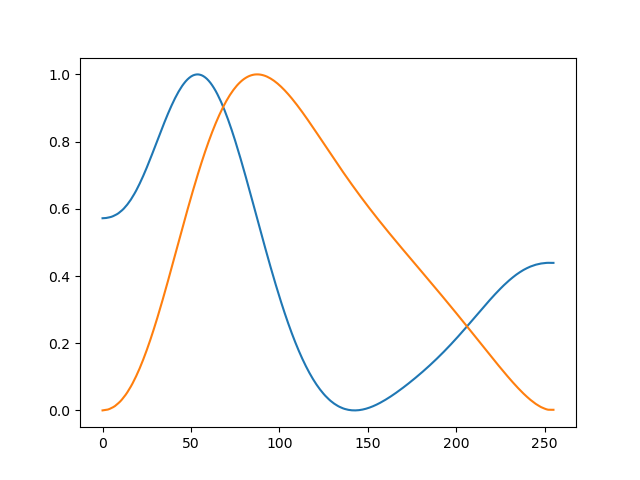

In [7]:
#Code to plot the templates 
plt.figure(1)
plt.plot(master_temp_2)
plt.plot(master_temp_1)
plt.show()

In [8]:
#Classification
#Classification of the pulses from the signals in files_to_classify. Comparison of each pulse with my 2 master templates with Pearson matrix. 
#If the maximum value between my 2 Pearson matrix is below the threshold = bad pulse (value 0), else good pulse (value 1)
#Update of the templates if I have 3 good pulses in a row (binary = 111)
path_file_art=[]
sum=[0]
alpha= 0#learning rate for the update of the templates 
th = 0.9#threshold for the correlation matrix
path_folder='database_Clara/files_to_classify'  
for i in range(len(files_to_classify)): #loop on the files to classify 
    path_file_art.append(path_folder + '/' + files_to_classify[0]) 
    _, ppg_signal_art, _,tm_art, fs = find_signal(path_file_art[0]) #return a column vector of the signal (ppg_signal_art) and time scale (tm_art)
    ppg_signal_art = ppg_signal_art[~np.isnan(ppg_signal_art)] #remove the NaN from the signal 
    pulse_norm_art, peaks, ppg_signal_filt, pulse_art, time_art, xq_art, pulse_resamp_art = preprocessing(ppg_signal_art,tm_art,fs,new_freq) #preprocessing 
    pulse_norm_art=minmax_scale(pulse_norm_art) #normalization by the max (output values between 0 and 1)
    rho1art = pearson(pulse_norm_art,master_temp_1) #correlation matrix between the matrix of pulses from a signal to classify and my 1st template
    rho2art = pearson(pulse_norm_art,master_temp_2) #correlation matrix between the matrix of pulses from a signal to classify and my 2nd template
    #output: rho has the same nbr of rows as first argument (=pulse_norm_art) of the function and same nbr of columns as the scnd argument (=template)
    # rho1art = np.ones((len(pulse_norm_art[0]), 1)) #values correlation matrix = 1 #just to try if the update was working  
    # rho2art = np.ones((len(pulse_norm_art[0]), 1))
    label=[]
    for i in range(len(rho1art)):
        rho1art=abs(rho1art) #values of the correlation matrix between -1 and 1 but to compare with the threshold has to be absolute values 
        rho2art=abs(rho2art)
        SQI=max(rho1art[i],rho2art[i]) #Signal Quality Index (SQI) will be compared with the threshold, SQI = max between 2 values of the 2 correlation matrices for the same row
        if SQI<th: #if the value of rho matrix is below the threshold the pulse is bad add 0 to a list 
            label.append(0) #0=bad, #1=good
        else: #the value of rho matrix is greater than the threshold pulse is good add 1 to a list
            label.append(1) #0=bad, #1=good
    #print(label)
        if i>=2 and i<len(rho1art):
            k=i-1
            if label[k]==1: #if the current pulse is good 
                if label[k-1]==0 and label[k+1]==0: #and if the the pulse before and after the previous pulse are bad
                    label[k]=0 #this pulse is not good #value 0
                else: 
                    master_temp_1=alpha*master_temp_1+(1-alpha)*pulse_norm_art[:,k] #update the templates 
                    master_temp_2=alpha*master_temp_2+(1-alpha)*pulse_norm_art[:,k] #equation: new template = alpha * current template + (1-alpha) * current pulse 
                    #alpha = learning rate 
                    rho1art = pearson(pulse_norm_art,master_temp_1) #because I have new templates, recalculation of the correlation matrix 
                    rho2art = pearson(pulse_norm_art,master_temp_2) 
#     master_temp_1, master_temp_2, label, rho1art, rho2art = classification(th,alpha,pulse_norm_art,master_temp_1,master_temp_2) #classification of the pulses 
#         #inputs: my 2 templates, matrix with the pulses to classify for each file (pulse_norm_art), threshold and learning rate 
#         #outputs: 2 templates updated, label = binary value for each pulse for ex [10001110], 2 Pearson matrices 
#     sum=sum+label #add label to sum for each file 
# y_pred=sum[1:] #y_pred is  a row vector composed of binary values from the classification of the pulses 

In [9]:
# #Classification
# #Classification of the pulses from the signals in files_to_classify. Comparison of each pulse with my 2 master templates with Pearson matrix. 
# #If the maximum value between my 2 Pearson matrix is below the threshold = bad pulse (value 0), else good pulse (value 1)
# #Update of the templates if I have 3 good pulses in a row (binary = 111)
# path_file_art=[]
# alpha = np.linspace(0,1,22) #learning rate for the update of the templates 
# th = np.linspace(0,1,22) #threshold for the correlation matrix
# path_folder='database_Clara/files_to_classify'  

# #Accuracy, sensitivity and specificity of the code 
# from sklearn.metrics import confusion_matrix
# #Classification: 0=bad, #1=good
# s31000198_0108=14*[0]+3*[1]+[0]
# s3100038_0162=7*[1]+13*[0]+16*[1]+[0]
# s3100198_0025=28*[0]+3*[1]
# s3100198_0028=28*[0]
# s3100198_0004=22*[0]
# s3100038_0097=5*[0]+17*[1]+[0]
# s3100198_0073=[0]+2*[1]+5*[0]
# s3100198_0066=10*[0]
# y_true = s31000198_0108+s3100038_0162+s3100198_0025+s3100198_0028+s3100198_0004+s3100038_0097+s3100198_0073+s3100198_0066
# #y_true is the row vector of the true classification for each pulse for each file made by myself by visualizing each pulse 

# Z=np.empty([len(alpha), len(th)])
# m=0
# j=0
# while m<len(alpha):
#     j=0
#     while j<len(th):
#         sum=[0]
#         for i in range(len(files_to_classify)): #loop on the files to classify 
#             path_file_art.append(path_folder + '/' + files_to_classify[i]) 
#             _, ppg_signal_art, _,tm_art, fs = find_signal(path_file_art[i]) #return a column vector of the signal (ppg_signal_art) and time scale (tm_art)
#             ppg_signal_art = ppg_signal_art[~np.isnan(ppg_signal_art)] #remove the NaN from the signal 
#             pulse_norm_art, peaks, ppg_signal_filt, pulse_art, time_art, xq_art, pulse_resamp_art = preprocessing(ppg_signal_art,tm_art,fs,new_freq) #preprocessing 
#             pulse_norm_art=minmax_scale(pulse_norm_art) #normalization by the max (output values between 0 and 1)
#             master_temp_1, master_temp_2, label, rho1art, rho2art = classification(th[j],alpha[m],pulse_norm_art,master_temp_1,master_temp_2) #classification of the pulses 
#             #inputs: my 2 templates, matrix with the pulses to classify for each file (pulse_norm_art), threshold and learning rate 
#             #outputs: 2 templates updated, label = binary value for each pulse for ex [10001110], 2 Pearson matrices 
#             sum=sum+label
#         y_pred=sum[1:] #y_pred is a row vector composed of binary values from the classification of the pulses 
#         tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() #confusion matrix 
#         #sensitivity=tp/(tp+fn)*100 #percentage of good pulses correctly identified 
#         #specificity=tn/(tn+fp)*100 #percentage of bad pulses correctly identified 
#         acc = (tp+tn)/(tp+tn+fp+fn)*100 #accuracy
#         Z[m,j]=acc
#         j=j+1
#     m=m+1


In [10]:
# plt.figure(1)
# plt.plot(ppg_signal_filt_art)
# plt.plot(peaks,ppg_signal_filt_art[peaks],'o')
# plt.show()

In [11]:
#Code to plot again the templates to see if they have been updated 
# plt.figure(2)
# plt.plot(master_temp_2)
# plt.plot(master_temp_1)
# plt.show()

In [12]:
# #Accuracy, sensitivity and specificity of the code 
# from sklearn.metrics import confusion_matrix
# #Classification: 0=bad, #1=good
# s31000198_0108=14*[0]+3*[1]+[0]
# s3100038_0162=7*[1]+13*[0]+16*[1]+[0]
# s3100198_0025=28*[0]+3*[1]
# s3100198_0028=28*[0]
# s3100198_0004=22*[0]
# s3100038_0097=5*[0]+17*[1]+[0]
# s3100198_0073=[0]+2*[1]+5*[0]
# s3100198_0066=10*[0]
# y_true = s31000198_0108+s3100038_0162+s3100198_0025+s3100198_0028+s3100198_0004+s3100038_0097+s3100198_0073+s3100198_0066
# #y_true is the row vector of the true classification for each pulse for each file made by myself by visualizing each pulse 
# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() #confusion matrix 
# sensitivity=tp/(tp+fn)*100 #percentage of good pulses correctly identified 
# specificity=tn/(tn+fp)*100 #percentage of bad pulses correctly identified 
# acc = (tp+tn)/(tp+tn+fp+fn)*100 #accuracy
# print(sensitivity,specificity,acc)

NameError: name 'Z' is not defined

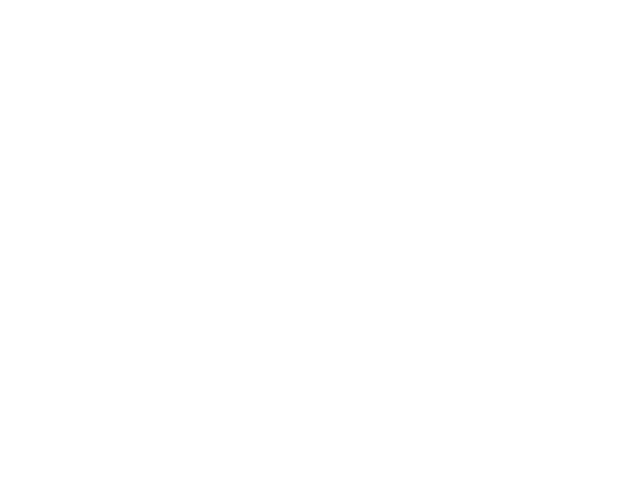

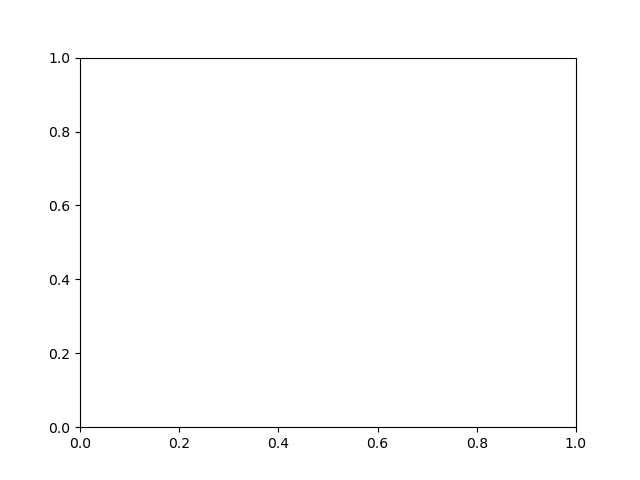

In [13]:
plt.figure(3)
xlist = th
ylist = alpha
X, Y = np.meshgrid(xlist, ylist)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Accuracy (%)')
ax.set_xlabel('threshold (th)')
ax.set_ylabel('learning rate (alpha)')
plt.show()

In [ ]:
#Figure for the classification (bad pulses in black)
# plt.figure()
# plt.plot(tm_art,ppg_signal_art)
# k=1
# for i in range(len(pulse_resamp_art[0])):
#     if k==len(row):
#         k=len(row)-1
#     if i==row[k]:
#         plt.plot(xq_art[:,i],pulse_resamp_art[:,i],'*k')
#         k=k+1 
# plt.show()

### 2) Detection of artefacts in ABP signals using energy ratio
This method classifies signals with artifacts using SNR. First, SVD is applied on a reference signal and the U matrix is divided into two subparts signal and noise. The ratio of the two parts gives us the SNR.

REF : https://iopscience.iop.org/article/10.1088/0967-3334/30/11/006

In [ ]:
#Path to the files in your folder
#The files must be downloaded first and put in the same folder 
# path1='mimic3wdb/31/3100038/3100038_0111' 
# path_art='mimic3wdb/31/3100038/3100038_0092' 

In [ ]:
#Template
# abp_signal1, _, _, _,tm1 = find_signal(path1)
# peaks1, pulse1, time1 = pulse_seg(ppg_signal_filt1,tm1)

# #Code to find the 90th percentile of the lengths of each columns : M
# l=np.empty([len(pulse1[0])])
# for i in range(len(pulse1[0])):
#     q=np.nonzero(pulse1[:,i])
#     l[i]=q[-1][-1]+1
# M=int(np.percentile(l,90))

# xq1, pulse_resamp1 = resampling(pulse1,time1, M)
# pulse_norm1 = normalizing(pulse_resamp1)

# #Artefacts
# abp_signal_art, _, _, _,tm_art = find_signal(path_art)
# peaks_art, pulse_art, time_art = pulse_seg(abp_signal_art,tm_art)
# xq_art, pulse_resamp_art = resampling(pulse_art,time_art, M)
# pulse_norm_art = normalizing(pulse_resamp_art)

# #Classification
# th = 1
# ratio, u, s, vh, row, kneedle, bad_pulses, good_pulses, total_pulses = energy_ratio(pulse_norm1,pulse_norm_art,th)

In [ ]:
# kneedle.plot_knee()
# plt.grid(True)

In [ ]:
#Figure for the classification (bad pulses in black)
# plt.figure(4)
# plt.subplot(2,1,1)
# plt.grid(True)
# plt.title('Pulse classification')
# plt.plot(tm1,abp_signal1)
# plt.subplot(2,1,2)
# plt.grid(True)
# plt.xlabel('Time (s)')
# plt.plot(tm_art,abp_signal_art)
# k=1
# for i in range(len(pulse_resamp_art[0])):
#     if k==len(row):
#         k=len(row)-1
#     if i==row[k]:
#         plt.plot(xq_art[:,i],pulse_resamp_art[:,i],'*k')
#         k=k+1 
# plt.show()